<p align="center" style=font-size:50px>Prediction Heart Failure</p>
<p align="center" style=font-size:30px>Modeling</p>
<p align="center">In this step, will be make a model of machine learning for classify if a person that had heart failure will survive or not.</p>

### Description of problem

A hospital wants to develop a machine learning model to predict whether or not a person with heart failure will survive during the patient's follow-up period. To develop this model, the hospital has a database that contains information on patients who had heart failure.

In [21]:
# import libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve,roc_auc_score,precision_recall_curve,precision_score,recall_score,auc
from sklearn.feature_selection import f_classif,SelectPercentile
from sklearn.preprocessing import OneHotEncoder


In [22]:
# load dataset
df = pd.read_csv('../data/df_cleaned.csv')

In [23]:
# Separating the features and response variable
X = df.drop('DEATH_EVENT',axis=1).copy()
y = df['DEATH_EVENT']

In [24]:
# Separating in train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=24)

First will be make a model with all features of dataset for predict response variable, after will be make again a model applying feature selection for choice a better features for predict response variable.

### Modeling with all features

In [25]:
#appling onehotencoding in the feature sex
ohe = OneHotEncoder(sparse_output=False)

X_train_encoded = ohe.fit_transform(X_train['sex'].values.reshape(-1,1))
X_test_encoded = ohe.transform(X_test['sex'].values.reshape(-1,1))

#convert arrays in dataframe
X_train_encoded_df = pd.DataFrame(X_train_encoded,columns=ohe.get_feature_names_out(['sex']))
X_test_encoded_df = pd.DataFrame(X_test_encoded,columns=ohe.get_feature_names_out(['sex']))

#reset index od dataframes train and test
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# concating the columns encoded with the original dataframes
X_train = pd.concat([X_train,X_train_encoded_df],axis=1)
X_test = pd.concat([X_test,X_test_encoded_df],axis=1)

# drop column sex
X_train.drop('sex',axis=1,inplace=True)
X_test.drop('sex',axis=1,inplace=True)


In [26]:
# creating a model
lr = LogisticRegression(solver='liblinear')

In [27]:
# avalaibe a model
# function for avalaibe the model 
def avalaibe_lr(lr: LogisticRegression,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series, y_test: pd.Series) -> pd.DataFrame:
    # traning a model
    lr.fit(X_train,y_train)
    # making predict
    y_pred = lr.predict(X_test)
    # calculatinf predicted probabilities
    y_pred_proba = lr.predict_proba(X_test)
    # calculating accuracy
    accuracy = accuracy_score(y_test,y_pred)
    # calculating recall
    recall = recall_score(y_test,y_pred)
    # calculating roc auc
    roc_auc = roc_auc_score(y_test,y_pred_proba[:,1])
    # calculating precision
    precision = precision_score(y_test,y_pred)
    df_metrics = pd.DataFrame(data=[[accuracy,recall,roc_auc,precision]],columns=['Accuracy','Recall','ROC AUC','Precision'])
    return df_metrics

df_metrics = avalaibe_lr(lr,X_train,X_test,y_train,y_test)

In [28]:
df_metrics

,Accuracy,Recall,ROC AUC,Precision
0,0.916667,0.764706,0.926129,0.928571


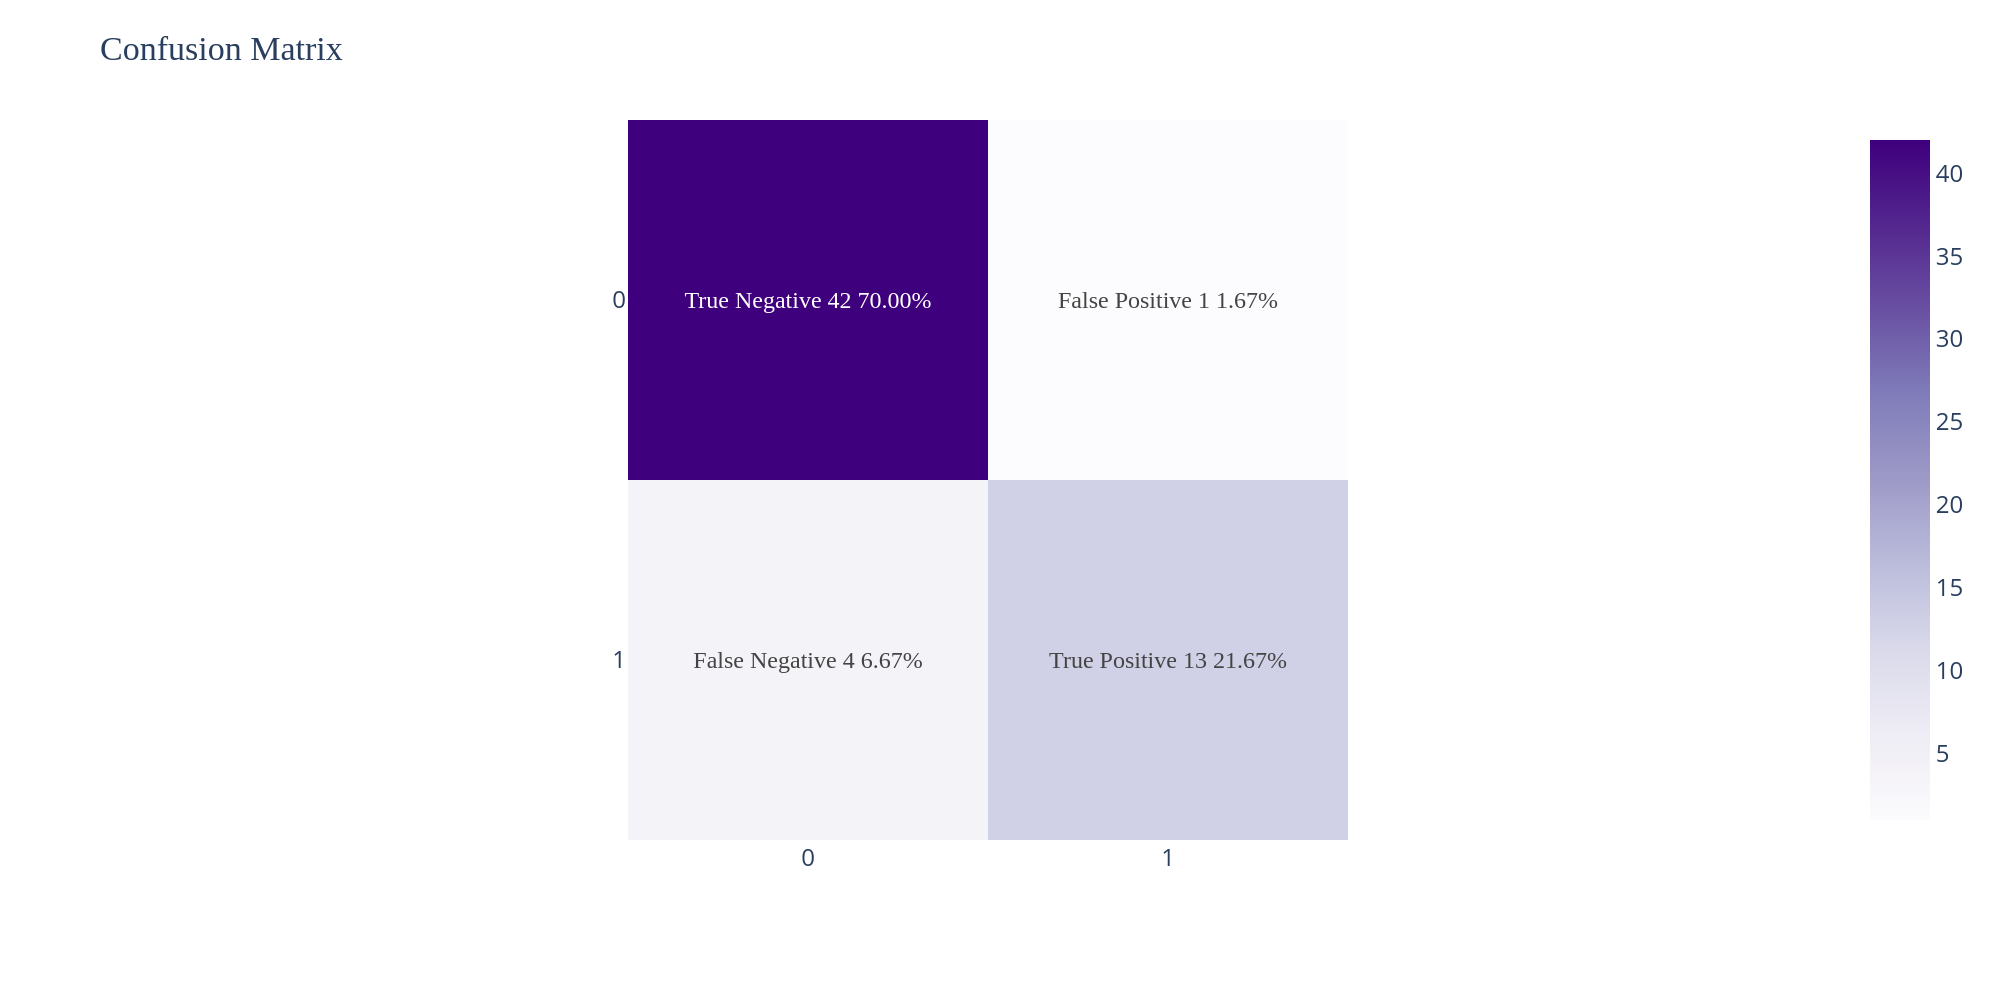

In [29]:
# function plot confusion matrix
def plot_cunfusion_matrix(lr: LogisticRegression,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series,y_test: pd.Series) -> None:
    # traning a model
    lr.fit(X_train,y_train)
    # making predict
    y_pred = lr.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    names = ['True Negative','False Positive','False Negative','True Positive']
    counts = [num for num in cm.flatten()]
    percents = [f'{num:.2%}' for num in cm.flatten()/np.sum(cm)]
    labels = [f'{value_1}\n{value_2}\n{value_3}' for value_1,value_2,value_3 in zip(names,counts,percents)]
    labels = np.asarray(labels).reshape(2,2)
    fig = px.imshow(cm,x=['0','1'],y=['0','1'],color_continuous_scale='purples')
    fig.update_traces(text=labels,texttemplate='%{text}',textfont = dict(size=12,family='Rockwell'))
    fig.update_layout(title = dict(text='Confusion Matrix',font_family='RockWell'),width=500)
    fig.show('png',scale=2,width=1000)

plot_cunfusion_matrix(lr,X_train,X_test,y_train,y_test)

Observing the confusion matrix above, the model with all features classified 4 false negative and this is bad, because the people that were classified as false negative dead.

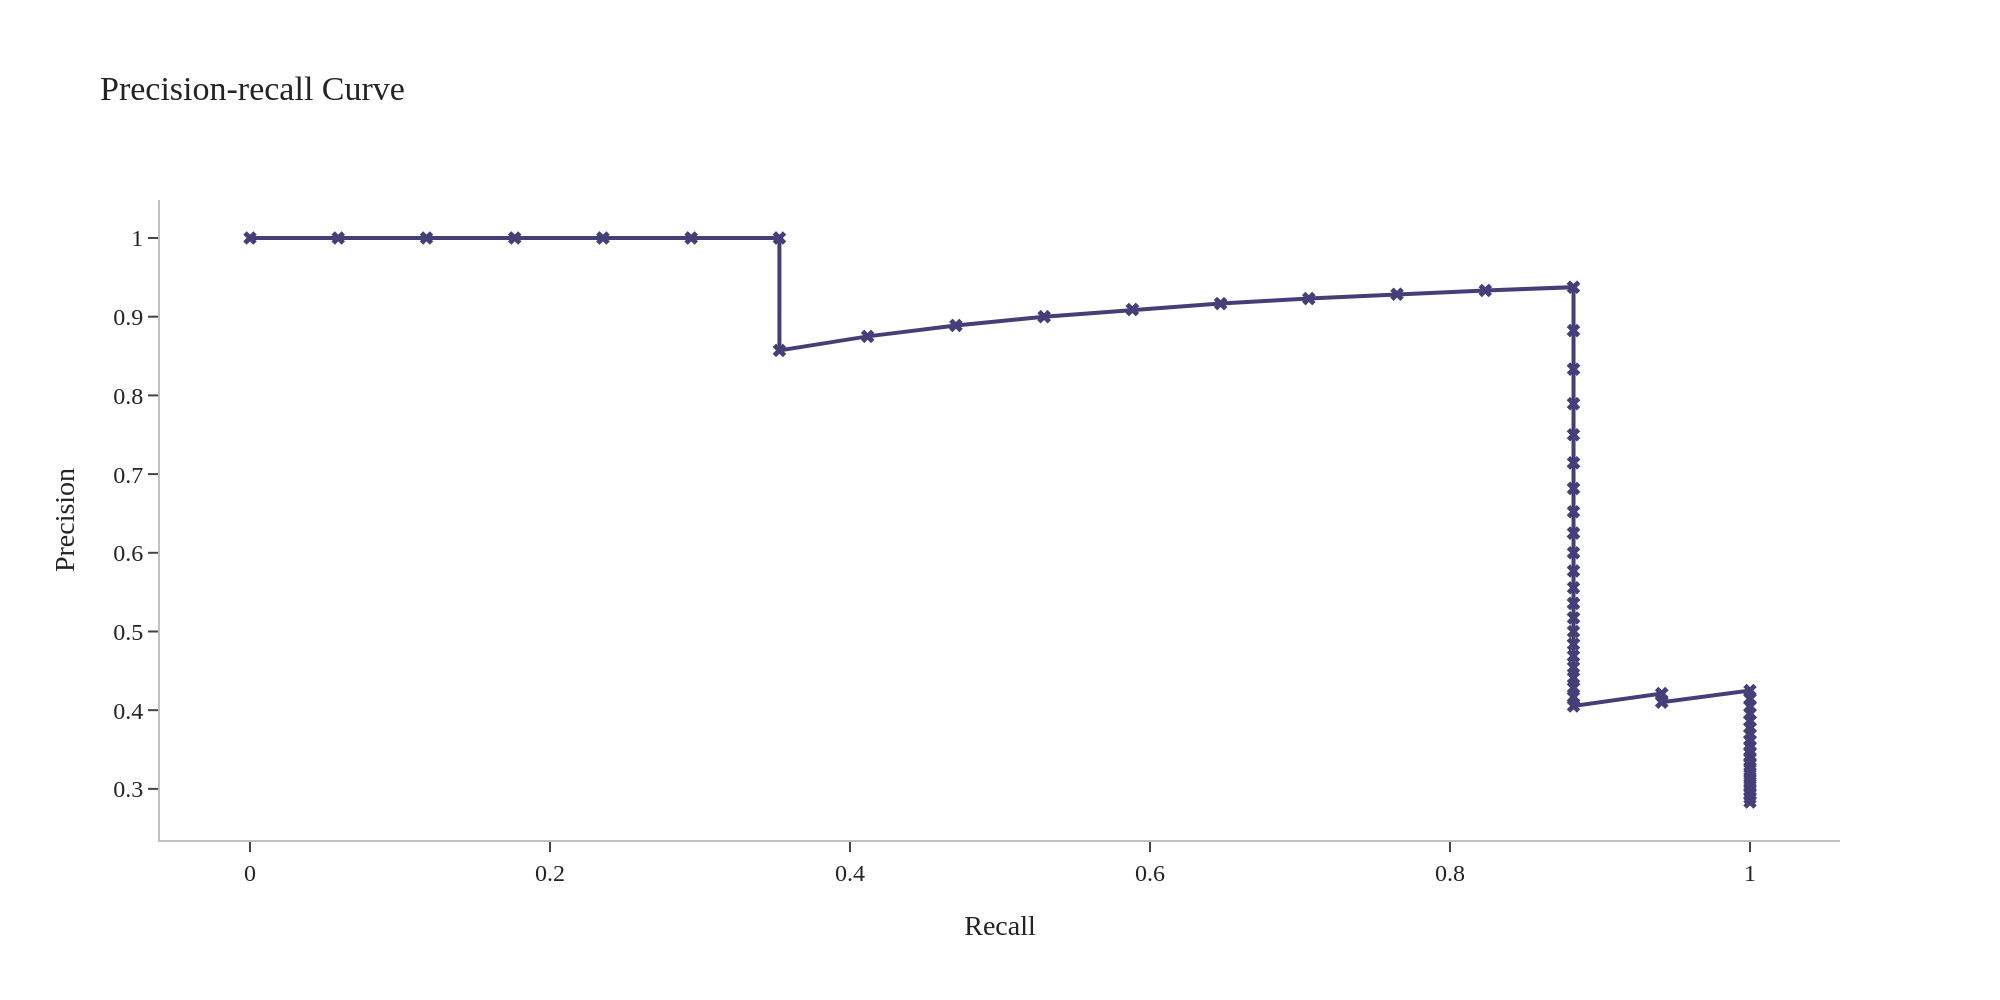

AUC precision-recall curve: 88.25%


In [30]:
def plot_precision_recall(lr: LogisticRegression,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series,y_test: pd.Series) -> None:
    # traning a model
    lr.fit(X_train,y_train)
    # making predict
    y_pred_proba = lr.predict_proba(X_test)
    precision,recall,threshold = precision_recall_curve(y_test,y_pred_proba[:,1])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=recall,y=precision,mode='lines+markers',marker_color='#453F78',marker_symbol='x',marker_size=0))
    fig.update_xaxes(title='Recall',linecolor='silver')
    fig.update_yaxes(title='Precision',linecolor='silver')
    fig.update_layout(title='Precision-recall Curve',template='simple_white',width=800,font_family='RockWell')
    fig.show('png',scale=2,width=1000)
    print(f'AUC precision-recall curve: {auc(recall,precision):.2%}')
plot_precision_recall(lr,X_train,X_test,y_train,y_test)

Can be observed that precision-recall curve and AUC show that precision is good for this model with all features.

### Modeling applying feature selection

In [31]:
# f-test
[f_stat,f_p_value] = f_classif(X_train,y_train)

f_test_df = pd.DataFrame({'Feature':X_train.columns,'F statistic':f_stat,'p value':f_p_value})
f_test_df.sort_values('p value')

,Feature,F statistic,p value
10,time,85.771739,1.260552e-17
4,ejection_fraction,18.414902,2.589849e-05
7,serum_creatinine,17.546412,3.957217e-05
0,age,14.364021,1.911322e-04
8,serum_sodium,6.201817,1.344810e-02
5,high_blood_pressure,2.927122,8.841112e-02
1,anaemia,0.828270,3.636980e-01
2,creatinine_phosphokinase,0.574930,4.490599e-01
3,diabetes,0.431639,5.118231e-01
9,smoking,0.193822,6.601558e-01


In [32]:
# choice top 20% of features according to the F-test
selector_features = SelectPercentile(f_classif,percentile=20)

selector_features.fit(X_train,y_train)

SelectPercentile(percentile=20)

In [33]:
# name best_features
best_features = selector_features.get_feature_names_out()
best_features

array(['ejection_fraction', 'serum_creatinine', 'time'], dtype=object)

In [34]:
# X_train and X_test with best features
X_train_best_features = X_train[best_features]
X_test_best_features = X_test[best_features]

df_metrics_best_features = avalaibe_lr(lr,X_train_best_features,X_test_best_features,y_train,y_test)

In [35]:
df_metrics_best_features

,Accuracy,Recall,ROC AUC,Precision
0,0.9,0.764706,0.948016,0.866667


Comparing with a model with all features, the model with best features there a increased in the ROC AUC, but the Precision descreased this show that model with best features is classifying more instances like positives, but this is bad because the number of false positives also will increse.

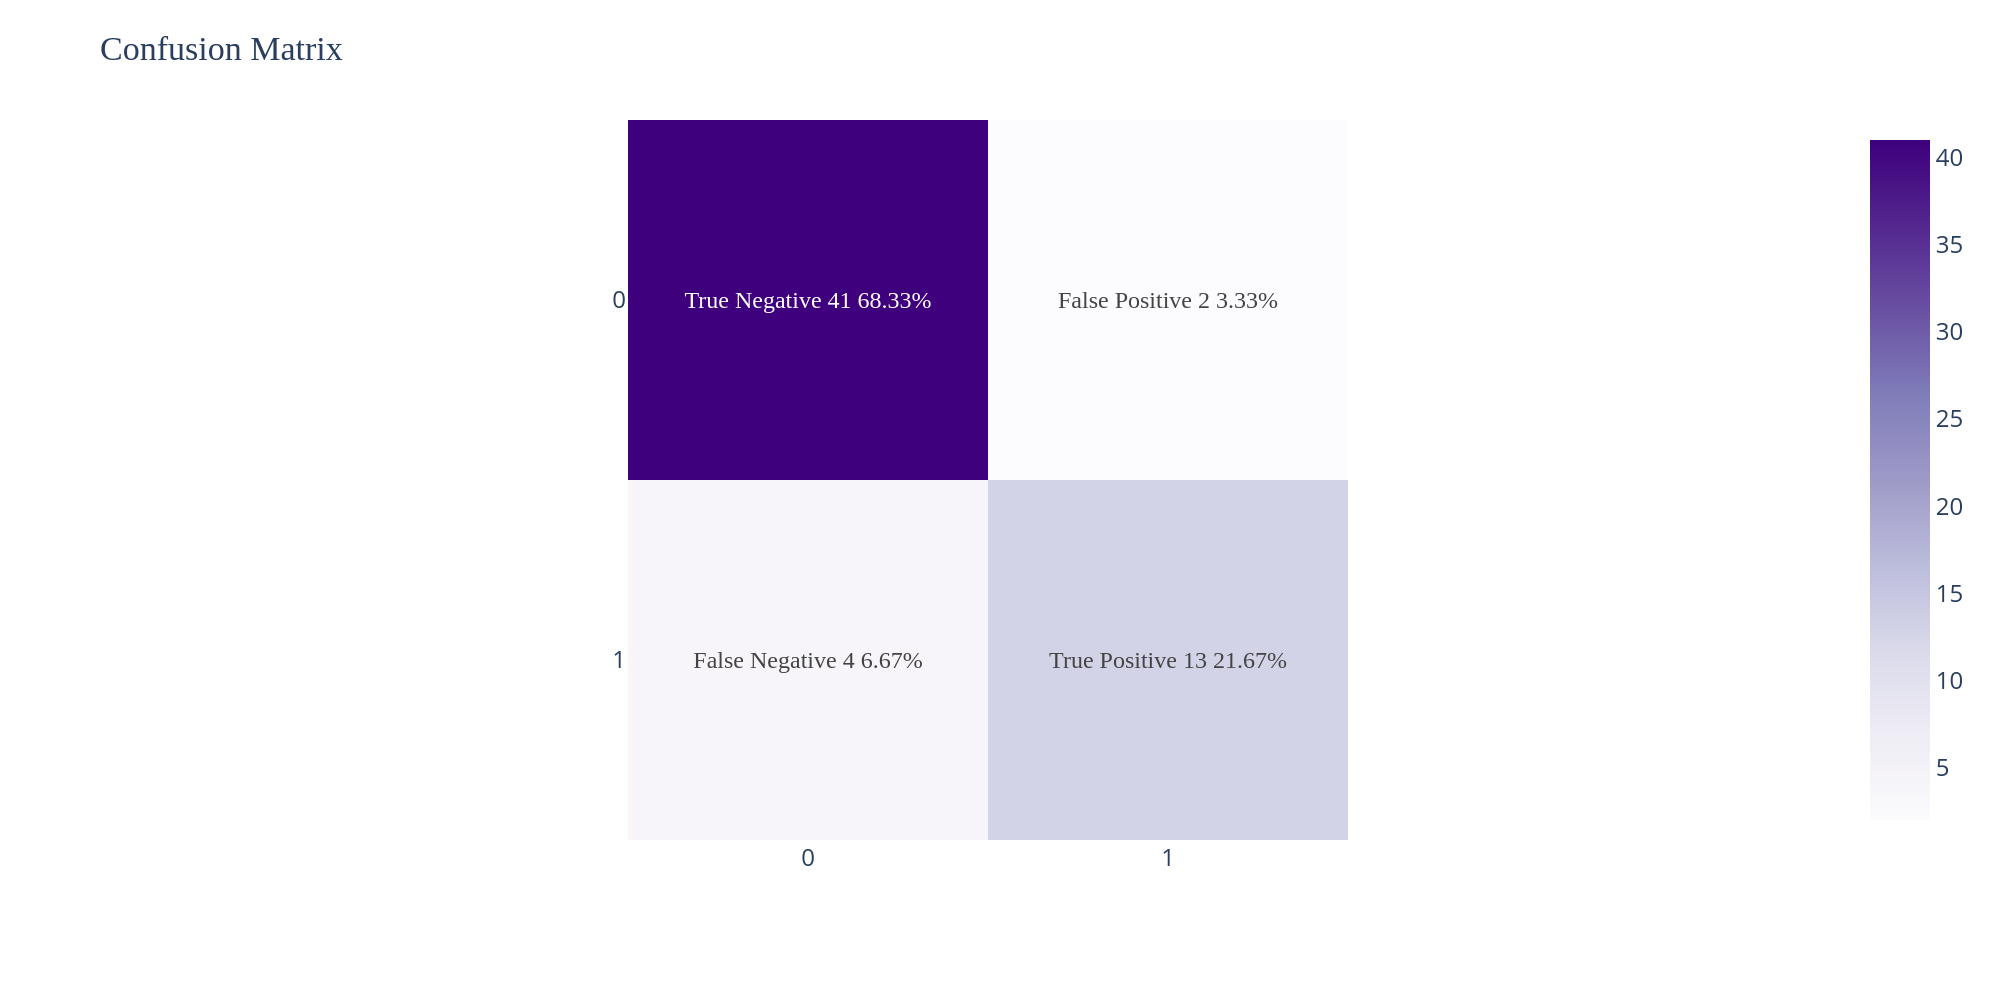

In [36]:
# ploting confusion matrix
plot_cunfusion_matrix(lr,X_train_best_features,X_test_best_features,y_train,y_test)

Some observations:
- As already mentioned above the model with best features is classifying more instances like positives and this also increase the number of false positive.
- Both the models couldn't decrease the number of false negative, despite having classified just 4 false negative this is bad because show that 4 people dead due a wrong classification.

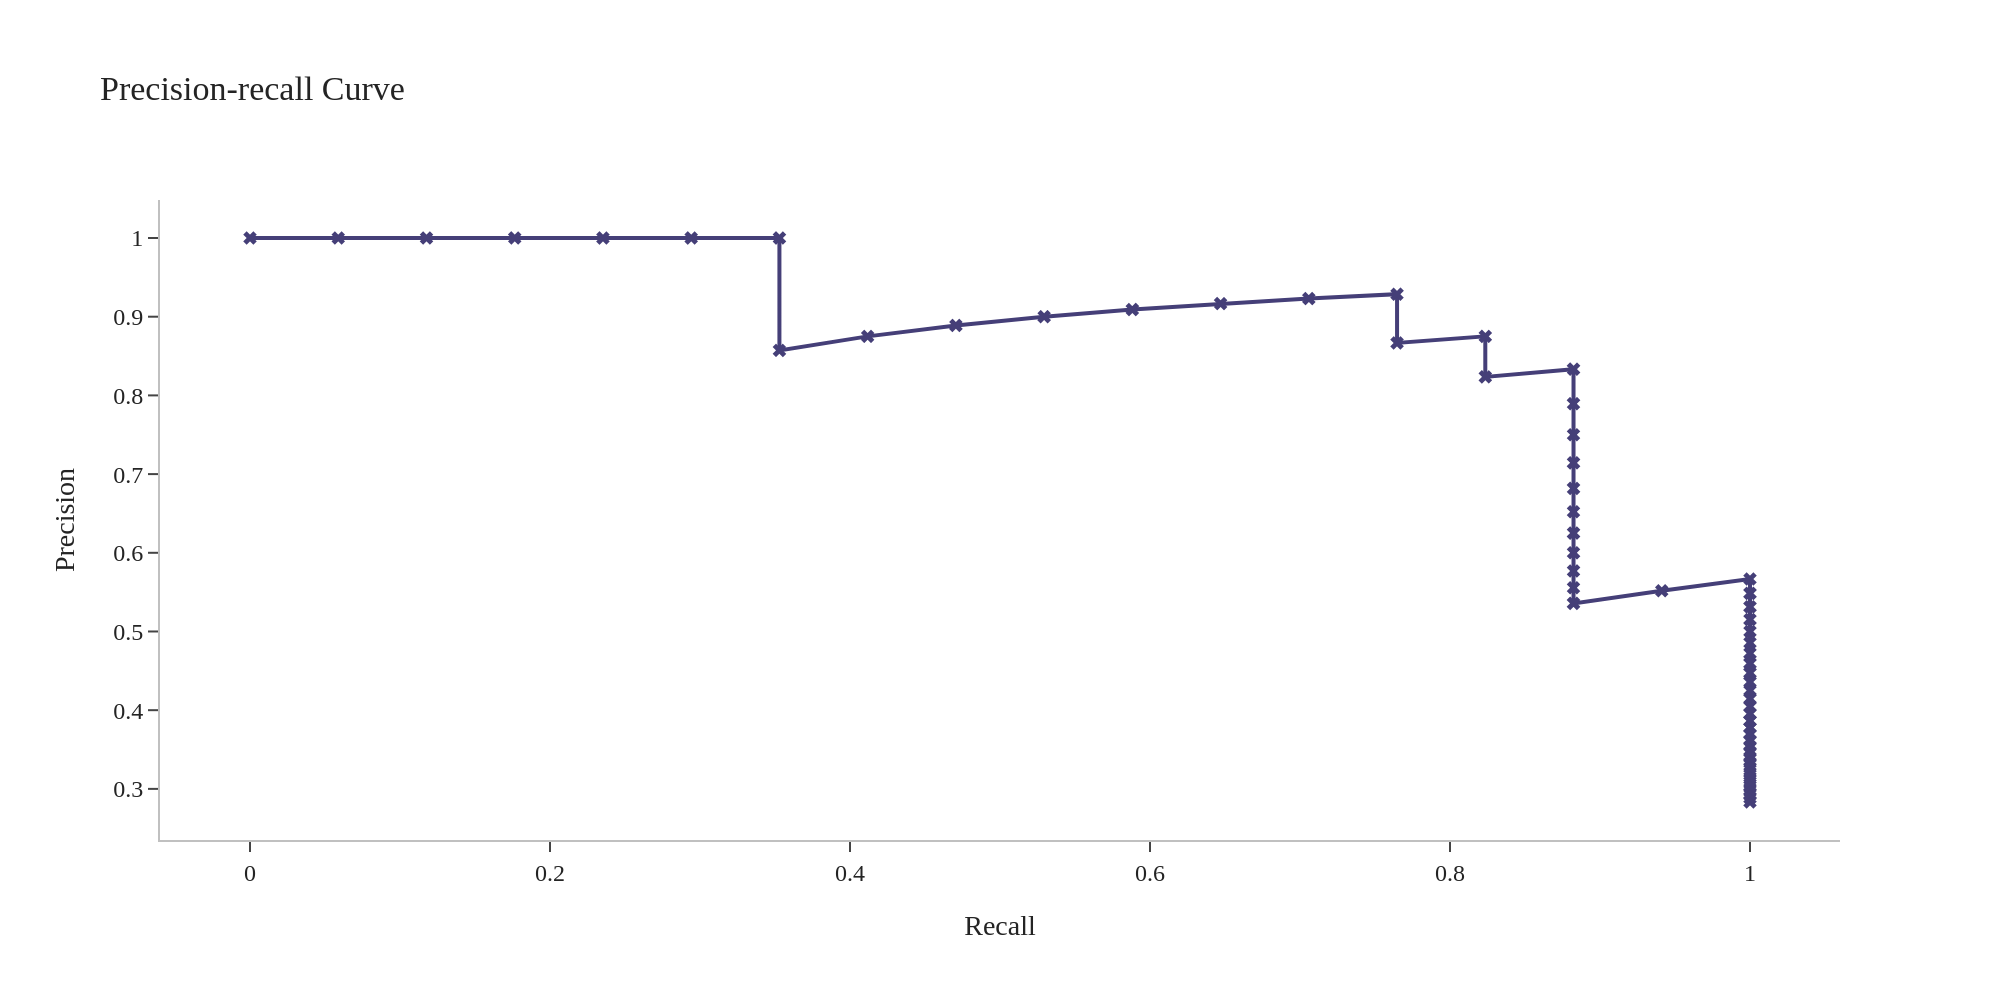

AUC precision-recall curve: 88.87%


In [37]:
# ploting precision recall curve
plot_precision_recall(lr,X_train_best_features,X_test_best_features,y_train,y_test)

Can be observed that precision-recall curve and AUC show that precision of model with best features is better for classify positives.

### Conclusion

In this project, the goal was develop a model of machine learning for predict if a person that had heart failure during follow-up would survive or not. Using a model with a best features obtained a perfomance a little better than with all features. But the model with best features can't decrease the number of false positives, perhaps with a larger dataset and using technics more advanced like feature engineering the model would permormance better. Despite that, the model had a good performance with a dataset that used.